**Introduction**: In this EDA notebook our approach leverages the power of the CLIP (Contrastive Language–Image Pretraining) model to extract high-quality embeddings from images. These embeddings capture deep semantic relationships between images, providing a rich numerical representation of their content.We will store embeddings for real and fake images for further analysis.We will verify that the embeddings generated by CLIP are properly normalized.To measure similarity between images,we will compute the pairwise dot product between embeddings.



Mount the Google Drive in a Google Colab environment



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%capture
!pip install torch==2.5.0 torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git

Load the dataset and generate image URLs


In [16]:
'''import pandas as pd
import urllib.request
import time

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data.txt', sep='\t')
df['url'] = 'https://i.pinimg.com/736x/' + df['signature'].str[0:2] + '/' + df['signature'].str[2:4] + '/' + df['signature'].str[4:6] + '/' + df['signature'] +'.jpg'
df['image_name'] = df['signature']
del df['signature']
df.head()
df.to_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')'''

In [ ]:
import pandas as pd
import urllib.request
import time

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')

for url in df['url'].to_list():
  file_name = url.split('/')[-1]
  time.sleep(1)
  try:
    urllib.request.urlretrieve(url, f'drive/MyDrive/colab_notebooks/images/{file_name}')
  except:
    print(url)

# Read images and generate CLIP embeddings

In below code we will set up the CLIP model from OpenAI and define a function to extract the embeddings from our images using the CLIP model.

In [7]:
!pip install open_clip_torch

import torch
import clip
from PIL import Image
import open_clip

#Select Device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

#Load CLIP Model & Preprocessing Function
model, preprocess = clip.load("ViT-B/32", device=device)

# Check embedding dimension
image_embedding_dim = model.visual.output_dim
print("Image Embedding Dimension:", image_embedding_dim)

#Define Function to Extract Image Embeddings
#This function takes an image path and returns a feature vector(embedding)
def get_image_embedddings(image_path):
  image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
  image_features = model.encode_image(image).cpu().detach().numpy().tolist()
  return image_features

Image Embedding Dimension: 512


Read the dataframe

In [82]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')
print(df.head())

   Unnamed: 0               query  is_ai_generated  \
0           0  Golden_Gate_Bridge                0   
1           1                Mars                1   
2           2                Mars                1   
3           3                Mars                1   
4           4                Mars                1   

                                                 url  \
0  https://i.pinimg.com/736x/35/45/03/354503ce717...   
1  https://i.pinimg.com/736x/d5/98/17/d59817583d8...   
2  https://i.pinimg.com/736x/3d/1d/e4/3d1de42b3f4...   
3  https://i.pinimg.com/736x/00/be/ca/00becac4c25...   
4  https://i.pinimg.com/736x/0a/5b/ae/0a5bae79ca6...   

                         image_name  
0  354503ce71788b2f7725480f7a96123c  
1  d59817583d8f5081d293afe840ea3da4  
2  3d1de42b3f41903ee6f768eb26de95c7  
3  00becac4c25ad5a0c839e1629bedb899  
4  0a5bae79ca67e303fe64e0db70565ed1  


In [75]:
df.count()

,0
query,3090
is_ai_generated,3090
signature,3090


In [83]:
df.describe()

,Unnamed: 0,is_ai_generated
count,3090.000000,3090.000000
mean,1544.500000,0.434304
std,892.150492,0.495745
min,0.000000,0.000000
25%,772.250000,0.000000
50%,1544.500000,0.000000
75%,2316.750000,1.000000
max,3089.000000,1.000000


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       3090 non-null   int64 
 1   query            3090 non-null   object
 2   is_ai_generated  3090 non-null   int64 
 3   url              3090 non-null   object
 4   image_name       3090 non-null   object
dtypes: int64(2), object(3)
memory usage: 120.8+ KB


In [85]:
df[df['is_ai_generated']==1].count()

,0
Unnamed: 0,1342
query,1342
is_ai_generated,1342
url,1342
image_name,1342


Real images count = 1748
AI generated images count = 1342

# Create a List to store all the embeddings

In [ ]:
import pandas as pd

embeddings = []
for index, row in df.iterrows():
  if index % 10 == 0: #helps track progress for large dataset.
    print(index)
  image_name = row['signature']
  image_features = get_image_embedddings(f'drive/MyDrive/colab_notebooks/images/{image_name}.jpg')
  label = row['is_ai_generated']
  image_features.append(image_name)
  image_features.append(label)
  embeddings.append(image_features)


df = pd.DataFrame(embeddings, columns=['embeddings', 'image_name', 'label'])
df.to_csv('drive/MyDrive/colab_notebooks/embeddings.csv')

Define a Normalization Function : Normalization will help to improve the performance for Cosine Similarity

In [54]:
import pandas as pd
import numpy as np
import torch

def normalize_vector(emb):
  pt_embedding = torch.tensor(emb)
  # Calculate the L2 norm
  norm = torch.norm(pt_embedding, p=2)
  # Normalize the embedding
  normalized_embedding = pt_embedding / norm
  return normalized_embedding


df = pd.read_csv('drive/MyDrive/colab_notebooks/embeddings.csv')
df.head()
#Compute Norm for the Embeddings
for index, embedding in enumerate(embeddings):
  if index > 5:
    break
  embedding_array=np.array(embedding[0])
  print("L2 Norm:", np.linalg.norm(embedding_array, ord=2))
  print(np.sum(embedding_array))
  print(np.mean(embedding_array))
  print('''''''normalized''''''')
  normalized_embedding = normalize_vector(embedding_array)
  normalized_embedding=np.array(normalized_embedding)
  print("L2 Norm:", np.linalg.norm(normalized_embedding, ord=2))
  print(np.sum(normalized_embedding))
  print(np.mean(normalized_embedding))
  print('''''''done''''''')


L2 Norm: 10.150701901825933
5.491922462941147
0.010726411060431928
normalized
L2 Norm: 1.0
0.5410386903346308
0.0010567161920598258
done
L2 Norm: 11.169297482396527
-23.18298449771828
-0.045279266597106016
normalized
L2 Norm: 1.0000000000000002
-2.075599162279995
-0.004053904613828116
done
L2 Norm: 10.457502999949275
-21.91262528009247
-0.042798096250180606
normalized
L2 Norm: 1.0000000000000002
-2.095397465360399
-0.004092573174532029
done
L2 Norm: 10.970089337995411
-21.818331113405293
-0.04261392795586971
normalized
L2 Norm: 1.0000000000000002
-1.9888927465555364
-0.003884556145616282
done
L2 Norm: 10.327972638161913
-13.110640290098672
-0.02560671931659897
normalized
L2 Norm: 1.0000000000000002
-1.2694301921032196
-0.002479355843951601
done
L2 Norm: 9.861645994181421
-15.452616009279154
-0.030180890643123348
normalized
L2 Norm: 1.0
-1.5669408553497584
-0.003060431358104997
done


# Read the embeddings in a csv file




In [86]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/colab_notebooks/label_data_with_url.txt', sep='\t')
print(df.head())

def string_to_float_array(s):
    s = s.replace('[', '').replace(']', '')
    return np.array([float(x) for x in s.split(',')])

df = pd.read_csv('drive/MyDrive/colab_notebooks/embeddings.csv')
del df['Unnamed: 0']
df['embeddings'] = df['embeddings'].apply(string_to_float_array)
df.head()

   Unnamed: 0               query  is_ai_generated  \
0           0  Golden_Gate_Bridge                0   
1           1                Mars                1   
2           2                Mars                1   
3           3                Mars                1   
4           4                Mars                1   

                                                 url  \
0  https://i.pinimg.com/736x/35/45/03/354503ce717...   
1  https://i.pinimg.com/736x/d5/98/17/d59817583d8...   
2  https://i.pinimg.com/736x/3d/1d/e4/3d1de42b3f4...   
3  https://i.pinimg.com/736x/00/be/ca/00becac4c25...   
4  https://i.pinimg.com/736x/0a/5b/ae/0a5bae79ca6...   

                         image_name  
0  354503ce71788b2f7725480f7a96123c  
1  d59817583d8f5081d293afe840ea3da4  
2  3d1de42b3f41903ee6f768eb26de95c7  
3  00becac4c25ad5a0c839e1629bedb899  
4  0a5bae79ca67e303fe64e0db70565ed1  


,embeddings,image_name,label
0,"[0.12522172927856445, 0.17127607762813568, -0....",354503ce71788b2f7725480f7a96123c,0
1,"[0.00956397969275713, -0.024535341188311577, -...",d59817583d8f5081d293afe840ea3da4,1
2,"[-0.014325050637125969, 0.026381907984614372, ...",3d1de42b3f41903ee6f768eb26de95c7,1
3,"[-0.09597162157297134, 0.10650302469730377, -0...",00becac4c25ad5a0c839e1629bedb899,1
4,"[0.368219792842865, 0.17371228337287903, -0.01...",0a5bae79ca67e303fe64e0db70565ed1,1


#Generate a heatmap for random 100 images from the pool which would display the pairwise dot product similarities.

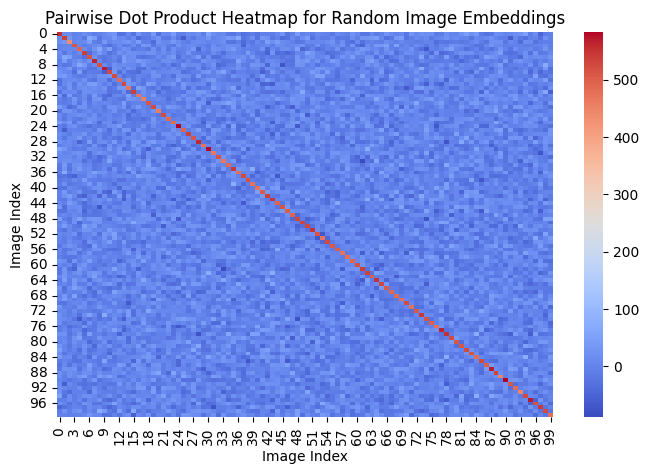

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_image_embedding_heatmap(num_images=100, embedding_dim=512):

    # Generate random embeddings (normally distributed)
    embeddings = np.random.randn(num_images, embedding_dim)

    # Compute pairwise dot product (Similarity Matrix)
    dot_product_matrix = np.dot(embeddings, embeddings.T)

    # Plot heatmap
    plt.figure(figsize=(8,5))
    sns.heatmap(dot_product_matrix, cmap="coolwarm", annot=False)
    plt.title("Pairwise Dot Product Heatmap for Random Image Embeddings")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    plt.show()

# Call the function to generate the heatmap
create_image_embedding_heatmap()


Summary from above Heatmap
1. The diagonal line red represents becasue the image is most similar to itself.
2. Because these are random images we dont see any strong similarity within the images.


# Cosine similarity

For embedddings direct from CLIP Model

In [89]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert embeddings to a numpy array
embeddings = np.array(df['embeddings'].to_list())

# Compute pairwise cosine similarity in one step
cosine_sim_matrix = cosine_similarity(embeddings)

# Print similarity values (if needed)
print(cosine_sim_matrix)


[[1.         0.53280955 0.49867255 ... 0.67975089 0.69353716 0.62649894]
 [0.53280955 1.         0.68945523 ... 0.57821919 0.5572134  0.53999406]
 [0.49867255 0.68945523 1.         ... 0.52249167 0.53043085 0.47858652]
 ...
 [0.67975089 0.57821919 0.52249167 ... 1.         0.79718971 0.81839241]
 [0.69353716 0.5572134  0.53043085 ... 0.79718971 1.         0.76904292]
 [0.62649894 0.53999406 0.47858652 ... 0.81839241 0.76904292 1.        ]]


For Normalized Embeddings

In [92]:
from sklearn.metrics.pairwise import cosine_similarity

# Create new column for normalized embeddings.
normalized_embeddings = []
for embedding in df['embeddings']:
  normalized_embeddings.append(normalize_vector(embedding))
# Compute pairwise cosine similarity in one step
normalized_cosine_sim_matrix = cosine_similarity(normalized_embeddings)

# Print similarity values (if needed)
print(normalized_cosine_sim_matrix)


[[1.         0.53280955 0.49867255 ... 0.67975089 0.69353716 0.62649894]
 [0.53280955 1.         0.68945523 ... 0.57821919 0.5572134  0.53999406]
 [0.49867255 0.68945523 1.         ... 0.52249167 0.53043085 0.47858652]
 ...
 [0.67975089 0.57821919 0.52249167 ... 1.         0.79718971 0.81839241]
 [0.69353716 0.5572134  0.53043085 ... 0.79718971 1.         0.76904292]
 [0.62649894 0.53999406 0.47858652 ... 0.81839241 0.76904292 1.        ]]


# t-SNE using cosine similarity

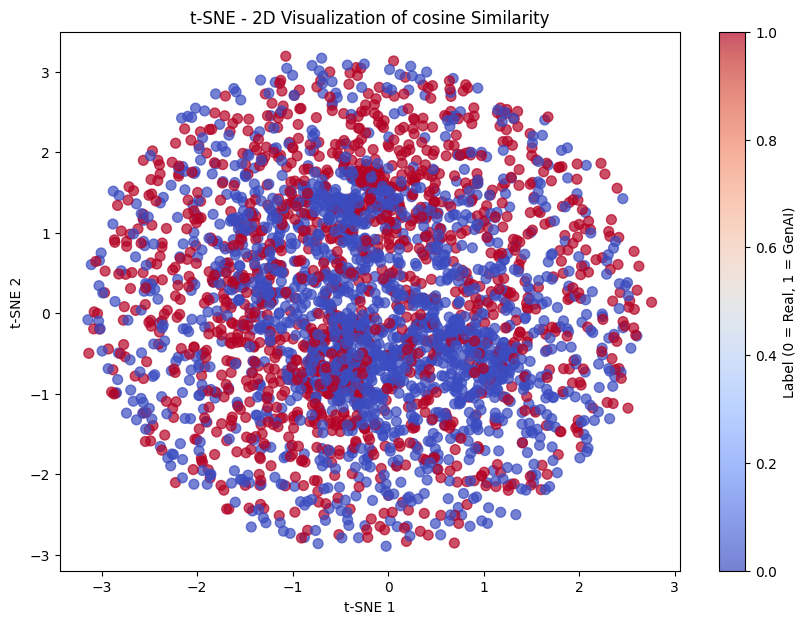

In [91]:
# for cosine similarity matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, init="random", metric="precomputed", random_state=42)
tsne_results = tsne.fit_transform(cosine_sim_matrix)

# Step 3: Plot the t-SNE scatter plot
'''plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], s=50)
plt.title("t-SNE Visualization of Image Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()'''

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df['label'], cmap='coolwarm', s=50, alpha=0.7)

# Step 4: Add color bar using the scatter object
plt.colorbar(scatter, label='Label (0 = Real, 1 = GenAI)')

plt.title('t-SNE - 2D Visualization of cosine Similarity')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Summary from above cosine similarity t-SNE
1. Some small red and blue dominating clusters and be observed which suggests that some embeddings do have distinguishing features.
2. Most of the embeddings show overlap which suggests distinguishing might be challenging.

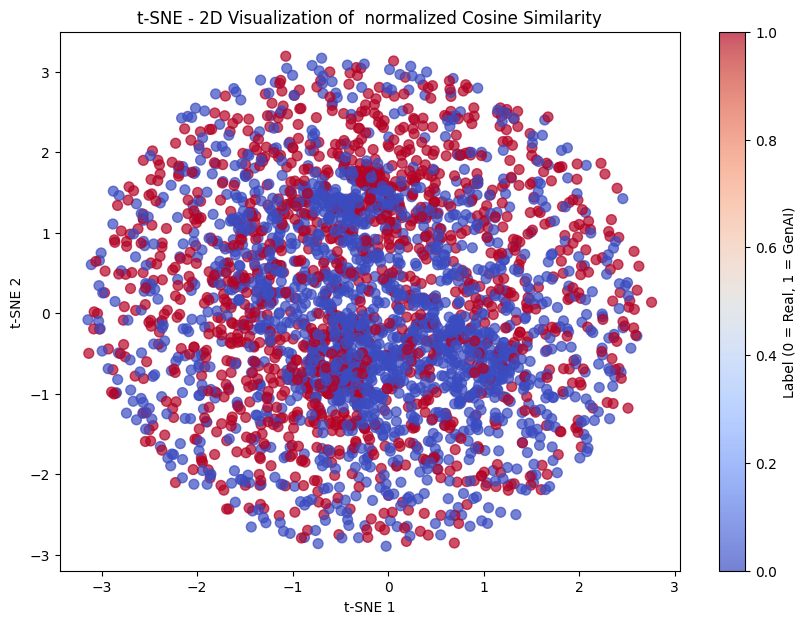

In [93]:
# for cosine similarity matrix with normalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Step 2: Apply t-SNE
tsne = TSNE(n_components=2, init="random", metric="precomputed", random_state=42)
tsne_results = tsne.fit_transform(normalized_cosine_sim_matrix)

# Step 3: Plot the t-SNE scatter plot
'''plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], s=50)
plt.title("t-SNE Visualization of Image Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()'''

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=df['label'], cmap='coolwarm', s=50, alpha=0.7)

# Step 4: Add color bar using the scatter object
plt.colorbar(scatter, label='Label (0 = Real, 1 = GenAI)')

plt.title('t-SNE - 2D Visualization of  normalized Cosine Similarity')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Summary from above Normalized Cosine similarity t-SNE
1. I dont see much difference between normalized as compared to not normalized t-SNE graphs.

In [61]:
%%capture
!pip install plotly dash

# Use PCA to reduce dimensions and visualize.

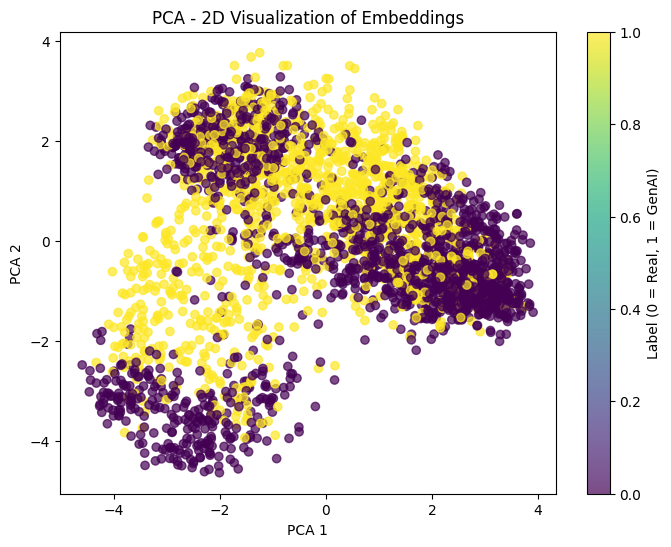

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Convert embeddings to a numpy array
embeddings = np.array(df['embeddings'].to_list())

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Add PCA results to dataframe
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Plot in 2D
plt.figure(figsize=(8, 6))
plt.scatter(df['pca_1'], df['pca_2'], c=df['label'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Label (0 = Real, 1 = GenAI)')
plt.title('PCA - 2D Visualization of Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


Summary from above chart
1. The embeddings from CLIP seem to have enough variance to form meaningful clusters.
2. If PCA 1 and PCA 2 had captured too little variance, the points would be tightly packed without clear clusters.
3. The fact that the clusters are spread out means that the embeddings have meaningful and discriminative features.
4. The clustering suggests that CLIP embeddings capture patterns that differentiate real and AI-generated images.
5. Overlapping areas suggest that some AI-generated images are highly realistic, making it difficult for the model to distinguish them.
6. The separation confirms that a classification model should be able to achieve high accuracy based on these embeddings.

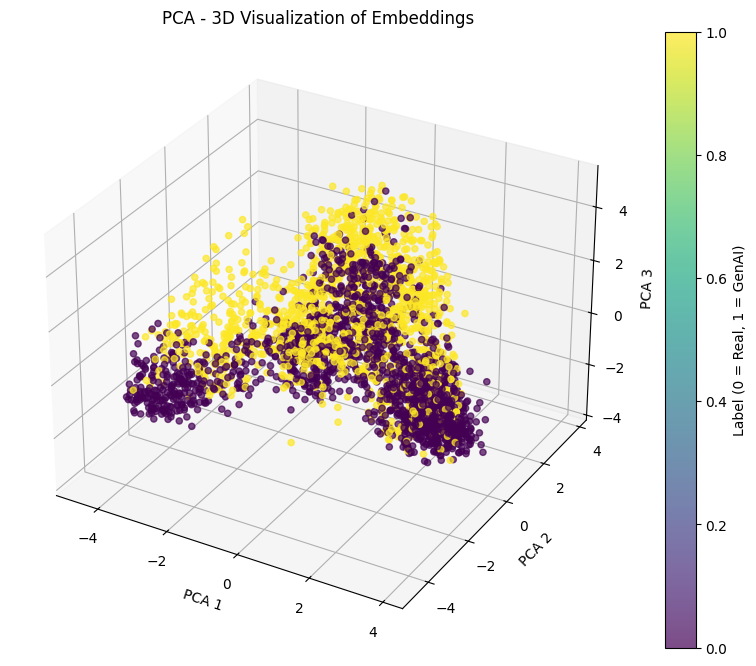

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for 3D visualization
pca = PCA(n_components=3)
pca_result = pca.fit_transform(embeddings)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                c=df['label'], cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Label (0 = Real, 1 = GenAI)')
ax.set_title('PCA - 3D Visualization of Embeddings')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.show()

Summary from above chart
1. There are distinct clusters forming, suggesting that the embeddings contain meaningful patterns that allow for separation.
2. Some degree of overlap → Certain AI-generated images closely resemble real ones.
3. The separation is clearer in 3D compared to the 2D plot, suggesting that the third component adds useful variance for discrimination.
4. The points are spread across all three PCA components → suggesting that the variance is not confined to just two dimensions.
5. The spread along PCA 3 means that the third component is capturing valuable discriminative patterns.
6. If the points were tightly clustered, the model would struggle to distinguish between real and AI-generated images.
7. The wide spread across PCA 1, PCA 2, and PCA 3 indicates that CLIP embeddings hold enough variance to support a classification model.
8. The embeddings form clearer clusters → Suggests that a classification model should be able to effectively learn the patterns.
9. Overlapping areas reflect that some AI-generated images are highly realistic.
10. A more complex model (like a vision transformer) might be needed to improve separation.
11. The separation suggests that clustering techniques (like KMeans or DBSCAN) could identify patterns without labels.
12. Cosine similarity on embeddings can be used to measure how close AI-generated images are to real ones.



#2D and 3D t-SNE for Visualization

t-SNE is more effective for capturing complex relationships and local structures in high-dimensional data

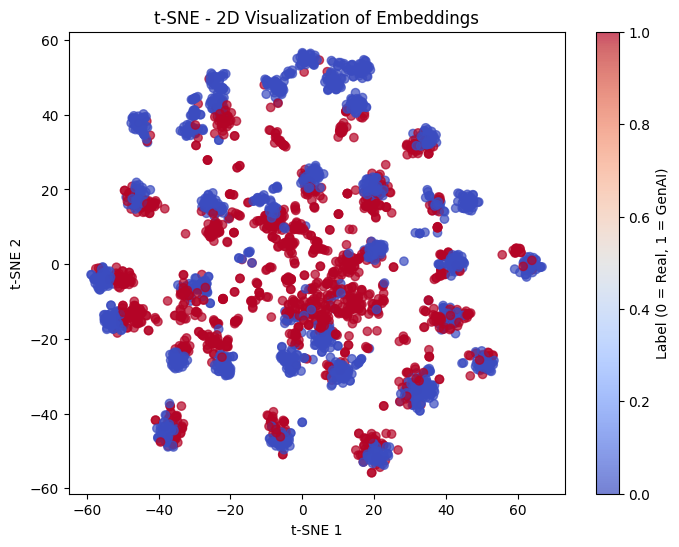

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Add t-SNE results to dataframe
df['tsne_1'] = tsne_result[:, 0]
df['tsne_2'] = tsne_result[:, 1]

# Plot in 2D
plt.figure(figsize=(8, 6))
plt.scatter(df['tsne_1'], df['tsne_2'], c=df['label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Label (0 = Real, 1 = GenAI)')
plt.title('t-SNE - 2D Visualization of Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Summary from above graph
1. The clusters indicate that the embeddings contain some identifiable differences between real and AI-generated images.
2. Clusters at the edges of the plot suggest that certain real or GenAI images are more distinctly different.
3. Overlapping areas (blue and red dots mixed) suggest that some AI-generated images resemble real ones.
4. This shows that certain AI-generated images might be harder to distinguish from real ones.
5. Good separation of clusters Embeddings are informative for classification.
6. High overlap More complex patterns requiring deeper feature extraction or more sophisticated models.


t-SNE for 3D visualization

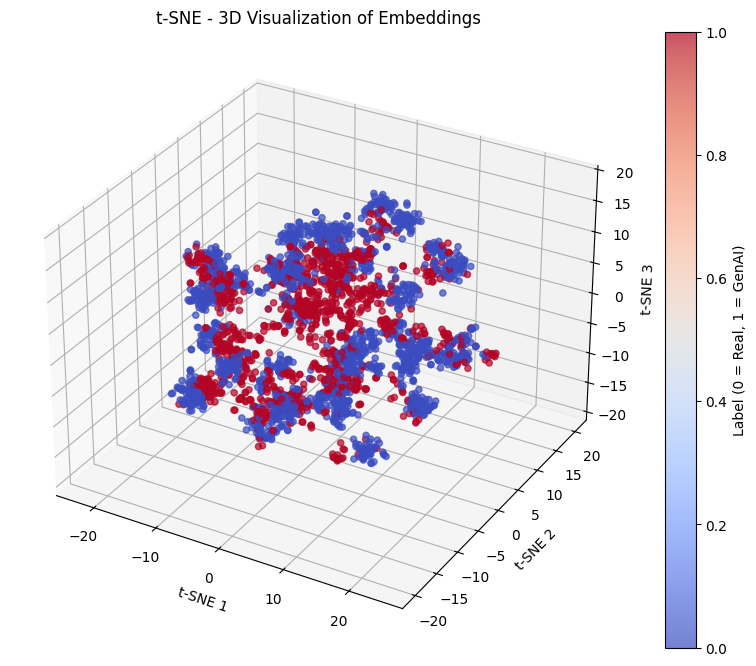

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2],
                c=df['label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(sc, label='Label (0 = Real, 1 = GenAI)')
ax.set_title('t-SNE - 3D Visualization of Embeddings')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.show()

Summary from the above graph
1. We can observe less overlapping, good seperated and distinct clusters. This suggests that Classification Models would work for training.

Summary for PCA and t-SNE
t-SNE is better at clustering high-dimensional data because it focuses on preserving local similarities.
Since embeddings from CLIP encode subtle differences in patterns (like textures, edges, and details), t-SNE helps reveal these fine-grain patterns more effectively than PCA.

